In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import pandas as pd
import pylhe
from tqdm import tqdm
import itertools

In [106]:
import os 
root_dirs = '../root/MG5_aMC_v2_7_3/SS2l_test/Events/'
root_dir = '../root/MG5_aMC_v2_7_3/SS2l/Events/'

In [107]:
root_names = ['run_01/tag_1_delphes_events.root', 'run_02/tag_1_delphes_events.root',
             'run_03/tag_1_delphes_events.root', 'run_04/tag_1_delphes_events.root',
             'run_05/tag_1_delphes_events.root', 'run_06/tag_1_delphes_events.root',
             'run_07/tag_1_delphes_events.root', 'run_08/tag_1_delphes_events.root',
             'run_09/tag_1_delphes_events.root', 'run_10/tag_1_delphes_events.root',
             'run_11/tag_1_delphes_events.root', 'run_12/tag_1_delphes_events.root',
             'run_13/tag_1_delphes_events.root', 'run_14/tag_1_delphes_events.root',
             'run_15/tag_1_delphes_events.root', 'run_16/tag_1_delphes_events.root',
             'run_17/tag_1_delphes_events.root', 'run_18/tag_1_delphes_events.root',
             'run_19/tag_1_delphes_events.root', 'run_20/tag_1_delphes_events.root',
             'run_21/tag_1_delphes_events.root', 'run_22/tag_1_delphes_events.root',
             'run_23/tag_1_delphes_events.root', 'run_24/tag_1_delphes_events.root']
root_name = ['run_01/tag_1_delphes_events.root', 'run_02/tag_1_delphes_events.root',
             'run_03/tag_1_delphes_events.root', 'run_04/tag_1_delphes_events.root',
             'run_05/tag_1_delphes_events.root', 'run_06/tag_1_delphes_events.root',
             'run_07/tag_1_delphes_events.root', 'run_08/tag_1_delphes_events.root']
f_tA = [uproot.open(root_dirs + name) for i, name in enumerate(root_names)]
f_tA1 = [uproot.open(root_dir + name) for i, name in enumerate(root_name)]

In [ ]:
f_tA[0]['Delphes;1'].show()

In [109]:
def f(deltaeta, deltaphi):
    return np.sqrt(deltaeta**2 + deltaphi**2)
def function(f_Att):
    # Define Tree
    tree_electron_Att = f_Att['Delphes;1/Electron']
    tree_muon_Att = f_Att['Delphes;1/Muon']
    tree_jet_Att = f_Att['Delphes;1/Jet']
    tree_Emiss_Att = f_Att['Delphes;1/MissingET']
    
    # Define Branches
    Att_electron = tree_electron_Att.arrays(['Electron.Charge',
                                            'Electron.PT',
                                            'Electron.Eta',
                                            'Electron.Phi'], library='ak')
    Att_muon = tree_muon_Att.arrays(['Muon.Charge',
                                    'Muon.PT',
                                    'Muon.Eta',
                                    'Muon.Phi'], library='ak')
    Att_jet = tree_jet_Att.arrays(['Jet.Mass',
                                   'Jet.BTag',
                                   'Jet.PT',
                                   'Jet.Eta', 
                                   'Jet.Phi'], library='ak')
    Att_Emiss = tree_Emiss_Att.arrays(['MissingET.MET',
                                       'MissingET.Phi'], library='ak')
    
    # Define Variables
    EventSize = len(Att_jet['Jet.Mass'])
    jet_sort_pt = ak.sort(Att_jet['Jet.PT'], axis=-1, ascending=False)
    jet_num = ak.num(Att_jet['Jet.PT'], axis=-1)
    lepton_sort_pt = ak.sort(ak.concatenate([Att_electron['Electron.PT'], Att_muon['Muon.PT']], axis=-1), axis=-1, ascending=False)
    lepton_charge = ak.Array.tolist(ak.concatenate([Att_electron['Electron.Charge'], Att_muon['Muon.Charge']], axis=-1))
    lepton_eta = ak.concatenate([Att_electron['Electron.Eta'], Att_muon['Muon.Eta']], axis=-1)
    lepton_phi = ak.concatenate([Att_electron['Electron.Phi'], Att_muon['Muon.Phi']], axis=-1)
    bjet_pt = Att_jet['Jet.PT']*Att_jet['Jet.BTag']
    bjet_eta = Att_jet['Jet.Eta']*Att_jet['Jet.BTag']
    bjet_phi = Att_jet['Jet.Phi']*Att_jet['Jet.BTag']
    two_electron = ak.where(ak.num(Att_electron['Electron.Eta'])>=2)
    two_muon = ak.where(ak.num(Att_muon['Muon.Eta'])>=2)
    two_lepton=ak.concatenate([two_electron, two_muon], axis=-1)
    
    # Two leptons with same charge + at least 3 jets with 2 of them identified as b-jets
    event_signal = []
    for i in tqdm(two_lepton[0]): #Awkward Array has a length of 1
        num_jet, b_pt, lep_charge = jet_num[i], bjet_pt[i], lepton_charge[i]
        num_bjet = len(b_pt[ak.where(b_pt)])
        if lep_charge.count(-1) >= 2 or lep_charge.count(1) >=2:
            if num_jet >= 3 and num_bjet >=2:
                event_signal.append(i)
        
    # Transverse Momentum of leading and subleading lepton $ Eta for Leptons
    event_lep = []
    for i in tqdm(event_signal):
        lep_eta = lepton_eta[i]
        lep_where = ak.where(np.abs(lep_eta)<2.5, 0, lep_eta)
        if lepton_sort_pt[i][0] > 25 and lepton_sort_pt[i][1] > 20 and ak.count_nonzero(lep_where) == 0:
            event_lep.append(i)
        else:
            continue
    
    # Transverse Momentum of leading and subleading b-jet & Eta for b-jets
    event_jet = []
    for i in tqdm(event_lep):
        b_pt, b_eta  = bjet_pt[i], bjet_eta[i]
        b_pt = b_pt[ak.where(b_pt)]
        b_pt = ak.sort(b_pt, ascending=False)
        bjet_where = ak.where(np.abs(b_eta)<2.5, 0, b_eta)
        if b_pt[0] > 30 and b_pt[1] > 20 and ak.count_nonzero(bjet_where) == 0:
            event_jet.append(i)
        else:
            continue
    
    # Emiss
    event_emiss = []
    for i in tqdm(event_jet):
        if Att_Emiss['MissingET.MET'][i] > 30:
            event_emiss.append(i)
        else:
            continue
 
    # delta R between b-jets and leptons, leptons and leptons, b-jets and b-jets
    event_deltaR_bl = []
    for i in tqdm(event_emiss):
        lep_eta, lep_phi, b_eta, b_phi = lepton_eta[i], lepton_phi[i], bjet_eta[i], bjet_phi[i]
        b_eta, b_phi = b_eta[ak.where(b_eta)], b_phi[ak.where(b_phi)]

        deltaeta_bl = np.array([i-j for i in b_eta for j in lep_eta])
        deltaphi_bl = np.abs([i-j for i in b_phi for j in lep_phi])
        deltaphi_bl = np.array([2*np.pi-i if i > np.pi else i for i in deltaphi_bl])
    
        if min(f(deltaeta_bl, deltaphi_bl)) > 0.4:
            event_deltaR_bl.append(i)
    
    event_deltaR_bb = []
    for i in tqdm(event_deltaR_bl):
        b_eta, b_phi = bjet_eta[i], bjet_phi[i]
        b_eta, b_phi = b_eta[ak.where(b_eta)], b_phi[ak.where(b_phi)]
        
        m = b_eta - b_eta[:, np.newaxis]
        deltaeta_bb = m[np.triu_indices(len(m[0]), k = 1)]
        m = b_phi - b_phi[:, np.newaxis]
        deltaphi_bb = np.abs(m[np.triu_indices(len(m[0]), k = 1)])
        deltaphi_bb = np.array([2*np.pi-i if i > np.pi else i for i in deltaphi_bb])
        
        if min(f(deltaeta_bb, deltaphi_bb)) > 0.4:
            event_deltaR_bb.append(i)
            
    event_deltaR_ll = []
    for i in tqdm(event_deltaR_bb):
        lep_eta, lep_phi = lepton_eta[i], lepton_phi[i]
        m = lep_eta - lep_eta[:, np.newaxis]
        deltaeta_ll = m[np.triu_indices(len(m[0]), k = 1)]
        m = lep_phi - lep_phi[:, np.newaxis]
        deltaphi_ll = np.abs(m[np.triu_indices(len(m[0]), k = 1)])
        deltaphi_ll = np.array([2*np.pi-i if i > np.pi else i for i in deltaphi_ll])

        if min(f(deltaeta_ll, deltaphi_ll)) > 0.4:
            event_deltaR_ll.append(i)
    
    # HT of 2 leading leptons and three leading jets
    event_ht = []
    for i in tqdm(event_deltaR_ll):
        lep_pt, jet_pt = lepton_sort_pt[i], jet_sort_pt[i]
        ht = np.sum([lep_pt[0], lep_pt[1], jet_pt[0], jet_pt[1], jet_pt[2]])
        if ht > 300:
            event_ht.append(i)
                
    return [EventSize, len(event_signal), len(event_lep), len(event_jet), len(event_emiss), len(event_deltaR_bl), len(event_deltaR_bb), len(event_deltaR_ll), len(event_ht)]

y1 = '../root/MG5_aMC_v2_7_3/test1/Events/run_01/tag_1_delphes_events.root'
y2 = uproot.open(y1)
y3 = function(y2)
y3

100%|██████████| 44/44 [00:00<00:00, 1522.43it/s]


[1000, 69, 54, 54, 46, 46, 46, 44, 40]

In [95]:
438/10000*35.11

1.537818

In [108]:
m1 = function(f_tA[0])
m2 = function(f_tA[1])
m3 = function(f_tA[2])
m4 = function(f_tA[3])
m5 = function(f_tA[4])
m6 = function(f_tA[5])
m7 = function(f_tA[6])
m8 = function(f_tA[7])
m9 = function(f_tA[8])
m10 = function(f_tA[9])
m11 = function(f_tA[10])
m12 = function(f_tA[11])
m13 = function(f_tA[12])
m14 = function(f_tA[13])
m15 = function(f_tA[14])
m16 = function(f_tA[15])
m17 = function(f_tA1[0])
m18 = function(f_tA1[1])
m19 = function(f_tA1[2])
m20 = function(f_tA1[3])
m21 = function(f_tA1[4])
m22 = function(f_tA1[5])
m23 = function(f_tA1[6])
m24 = function(f_tA1[7])

100%|██████████| 653/653 [00:00<00:00, 1837.78it/s]


In [110]:
m_01 = [m1, m2, m3, m4, m5, m6, m7, m8]
name = [r'Input Event Size',
        'SS2l Signature',
        r'leading jets > 30 GeV & subleading jets > 20 GeV & $|η^{l}|< 2.5$',
        r'leading leptons > 25 GeV & subleading leptons > 20 GeV & $|η^{b}| < 2.5$',
        r'$E_{T}^{miss}$ > 30GeV',
        r'Δ$R_{bb}$ > 0.4',
        r'Δ$R_{bl}$ > 0.4',
        r'Δ$R_{ll}$ > 0.4',
        r'$H_{T}$ (2 leading leptons & 3 leading jets) > 300 GeV']
fd = pd.DataFrame({r'Selection Cut (SS2l) $\rho_{tc}=0.1$': name,
                   r'$M_{A}=350 GeV$': m_01[0],
                   r'$M_{A}=400 GeV$': m_01[1],
                   r'$M_{A}=450 GeV$': m_01[2],
                   r'$M_{A}=500 GeV$': m_01[3],
                   r'$M_{A}=550 GeV$': m_01[4],
                   r'$M_{A}=600 GeV$': m_01[5],
                   r'$M_{A}=650 GeV$': m_01[6],
                   r'$M_{A}=700 GeV$': m_01[7],
                   })
fd

,Selection Cut (SS2l) $\rho_{tc}=0.1$,$M_{A}=350 GeV$,$M_{A}=400 GeV$,$M_{A}=450 GeV$,$M_{A}=500 GeV$,$M_{A}=550 GeV$,$M_{A}=600 GeV$,$M_{A}=650 GeV$,$M_{A}=700 GeV$
0,Input Event Size,1000,1000,1000,1000,1000,1000,1000,1000
1,SS2l Signature,80,84,95,97,103,103,89,103
2,leading jets > 30 GeV & subleading jets > 20 G...,69,72,76,80,84,86,72,94
3,leading leptons > 25 GeV & subleading leptons ...,66,71,74,79,81,86,71,94
4,$E_{T}^{miss}$ > 30GeV,58,56,68,73,73,77,63,88
5,Δ$R_{bb}$ > 0.4,58,56,68,73,73,77,63,88
6,Δ$R_{bl}$ > 0.4,58,56,68,73,73,77,63,88
7,Δ$R_{ll}$ > 0.4,57,56,67,71,72,75,62,86
8,$H_{T}$ (2 leading leptons & 3 leading jets) >...,45,52,64,70,71,72,61,85


In [111]:
m_05 = [m9, m10, m11, m12, m13, m14, m15, m16]
name = [r'Input Event Size',
        'SS2l Signature',
        r'leading jets > 30 GeV & subleading jets > 20 GeV & $|η^{l}|< 2.5$',
        r'leading leptons > 25 GeV & subleading leptons > 20 GeV & $|η^{b}| < 2.5$',
        r'$E_{T}^{miss}$ > 30 GeV',
        r'Δ$R_{bb}$ > 0.4',
        r'Δ$R_{bl}$ > 0.4',
        r'Δ$R_{ll}$ > 0.4',
        r'$H_{T}$ (2 leading leptons & 3 leading jets) > 300 GeV']
fd = pd.DataFrame({r'Selection Cut (SS2l) $\rho_{tc}=0.5$': name,
                   r'$M_{A}=350 GeV$': m_05[0],
                   r'$M_{A}=400 GeV$': m_05[1],
                   r'$M_{A}=450 GeV$': m_05[2],
                   r'$M_{A}=500 GeV$': m_05[3],
                   r'$M_{A}=550 GeV$': m_05[4],
                   r'$M_{A}=600 GeV$': m_05[5],
                   r'$M_{A}=650 GeV$': m_05[6],
                   r'$M_{A}=700 GeV$': m_05[7],
                   })
fd

,Selection Cut (SS2l) $\rho_{tc}=0.5$,$M_{A}=350 GeV$,$M_{A}=400 GeV$,$M_{A}=450 GeV$,$M_{A}=500 GeV$,$M_{A}=550 GeV$,$M_{A}=600 GeV$,$M_{A}=650 GeV$,$M_{A}=700 GeV$
0,Input Event Size,5000,5000,5000,5000,5000,5000,5000,5000
1,SS2l Signature,353,459,453,466,482,474,482,458
2,leading jets > 30 GeV & subleading jets > 20 G...,272,370,376,379,380,397,419,379
3,leading leptons > 25 GeV & subleading leptons ...,266,364,370,375,371,386,407,370
4,$E_{T}^{miss}$ > 30 GeV,238,330,338,344,339,361,378,334
5,Δ$R_{bb}$ > 0.4,238,330,338,344,339,361,378,334
6,Δ$R_{bl}$ > 0.4,238,330,338,344,339,361,378,334
7,Δ$R_{ll}$ > 0.4,235,326,336,339,336,351,372,331
8,$H_{T}$ (2 leading leptons & 3 leading jets) >...,207,305,316,326,332,350,365,326


In [112]:
m_10 = [m17, m18, m19, m20, m21, m22, m23, m24]
name = [r'Input Event Size',
        'SS2l Signature',
        r'leading jets > 30 GeV & subleading jets > 20 GeV & $|η^{l}|< 2.5$',
        r'leading leptons > 25 GeV & subleading leptons > 20 GeV & $|η^{b}| < 2.5$',
        r'$E_{T}^{miss}$ > 30 GeV',
        r'Δ$R_{bb}$ > 0.4',
        r'Δ$R_{bl}$ > 0.4',
        r'Δ$R_{ll}$ > 0.4',
        r'$H_{T}$ (2 leading leptons & 3 leading jets) > 300 GeV']
fd = pd.DataFrame({r'Selection Cut (SS2l) $\rho_{tc}=1.0$': name,
                   r'$M_{A}=350 GeV$': m_10[0],
                   r'$M_{A}=400 GeV$': m_10[1],
                   r'$M_{A}=450 GeV$': m_10[2],
                   r'$M_{A}=500 GeV$': m_10[3],
                   r'$M_{A}=550 GeV$': m_10[4],
                   r'$M_{A}=600 GeV$': m_10[5],
                   r'$M_{A}=650 GeV$': m_10[6],
                   r'$M_{A}=700 GeV$': m_10[7],
                   })
fd

,Selection Cut (SS2l) $\rho_{tc}=1.0$,$M_{A}=350 GeV$,$M_{A}=400 GeV$,$M_{A}=450 GeV$,$M_{A}=500 GeV$,$M_{A}=550 GeV$,$M_{A}=600 GeV$,$M_{A}=650 GeV$,$M_{A}=700 GeV$
0,Input Event Size,10000,10000,10000,10000,10000,10000,10000,10000
1,SS2l Signature,751,775,835,794,865,824,870,908
2,leading jets > 30 GeV & subleading jets > 20 G...,575,623,654,656,702,680,710,728
3,leading leptons > 25 GeV & subleading leptons ...,565,611,646,643,691,666,697,712
4,$E_{T}^{miss}$ > 30 GeV,485,544,574,575,629,615,638,664
5,Δ$R_{bb}$ > 0.4,485,544,574,575,629,615,638,664
6,Δ$R_{bl}$ > 0.4,485,544,574,575,629,615,638,664
7,Δ$R_{ll}$ > 0.4,476,533,562,568,615,607,627,653
8,$H_{T}$ (2 leading leptons & 3 leading jets) >...,426,495,540,546,601,605,616,647


In [113]:
f_01 = [m_01[i][-1]/m_01[i][0] for i in range(len(m_01))]
f_05 = [m_05[i][-1]/m_05[i][0] for i in range(len(m_05))]
f_10 = [m_10[i][-1]/m_10[i][0] for i in range(len(m_10))]

In [101]:
f_01

[0.045, 0.052, 0.064, 0.07, 0.071, 0.072, 0.061, 0.085]

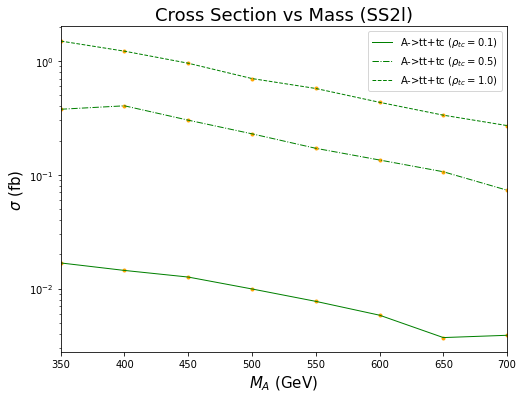

In [114]:
ma = np.linspace(350, 700, 8)
ss2l_a01 = [0.0003737, 0.0002779, 0.0001975, 0.0001419, 0.0001089, 8.117e-05, 6.092e-05, 4.579e-05]
ss2l_a05 = [0.009095, 0.006619, 0.004778, 0.003513, 0.002574, 0.001927, 0.001457, 0.001123]
ss2l_a10 = [0.03511, 0.02463, 0.01769, 0.01283, 0.009539, 0.007162, 0.005423, 0.004183]
ss2l_a01f = [ss2l_a01[i] * 1000 * f_01[i] for i in range(8)]
ss2l_a05f = [ss2l_a05[i] * 1000 * f_05[i] for i in range(8)]
ss2l_a10f = [ss2l_a10[i] * 1000 * f_10[i] for i in range(8)]
plt.figure(figsize=(8, 6))
plt.scatter(ma, ss2l_a01f, marker='.', c='orange')
plt.scatter(ma, ss2l_a05f, marker='.', c='orange')
plt.scatter(ma, ss2l_a10f, marker='.', c='orange')
plt.xlim(350, 700)
plt.yscale('log')
plt.plot(ma, ss2l_a01f, 'g-', label=r'A->tt+tc ($\rho_{tc}=0.1$)', linewidth=1)
plt.plot(ma, ss2l_a05f, 'g-.', label=r'A->tt+tc ($\rho_{tc}=0.5$)', linewidth=1)
plt.plot(ma, ss2l_a10f, 'g--', label=r'A->tt+tc ($\rho_{tc}=1.0$)', linewidth=1)

plt.title('Cross Section vs Mass (SS2l)', fontsize=18)
plt.xlabel(r'$M_{A}$ (GeV)', fontsize=15)
plt.ylabel(r'$\sigma$ (fb)', fontsize=15)
plt.legend(loc='upper right')
plt.show()

In [115]:
y1 = '../root/MG5_aMC_v2_7_3/test1/Events/run_01/tag_1_delphes_events.root'
y2 = uproot.open(y1)
y3 = function(y2)

100%|██████████| 60/60 [00:00<00:00, 1369.70it/s]


In [118]:
0.1273 * y3[-1]/y3[0]

0.0071288

In [70]:
m_10 = [m17, m18, m19, m20, m21, m22, m23, m24]
name = [r'Input Event Size',
        'SS2l Signature',
        r'leading jets > 30 GeV & subleading jets > 20 GeV & $|η^{l}|< 2.5$',
        r'leading leptons > 25 GeV & subleading leptons > 20 GeV & $|η^{b}| < 2.5$',
        r'$E_{T}^{miss}$',
        r'Δ$R_{bb}$ > 0.4',
        r'Δ$R_{bl}$ > 0.4',
        r'Δ$R_{ll}$ > 0.4',
        r'$H_{T}$ (2 leading leptons & 3 leading jets) > 300 GeV']
fd = pd.DataFrame({r'Selection Cut (SS2l)$\rho_{tc}=1.0$': name,
                   r'$M_{A}=350 GeV$': y3
                   })
fd

,Selection Cut (SS2l)$\rho_{tc}=1.0$,$M_{A}=350 GeV$
0,Input Event Size,10000
1,SS2l Signature,1474
2,leading jets > 30 GeV & subleading jets > 20 G...,1169
3,leading leptons > 25 GeV & subleading leptons ...,1145
4,$E_{T}^{miss}$,994
5,Δ$R_{bb}$ > 0.4,994
6,Δ$R_{bl}$ > 0.4,994
7,Δ$R_{ll}$ > 0.4,975
8,$H_{T}$ (2 leading leptons & 3 leading jets) >...,876


In [104]:
fd = pd.DataFrame({'Mass of A0 (GeV) (before cut)': ma,
                   '𝜎 (𝜌𝑡𝑐=0.1)': [i * 1000 for i in ss2l_a01],
                   '𝜎 (𝜌𝑡𝑐=0.5)': [i * 1000 for i in ss2l_a05],
                   '𝜎 (𝜌𝑡𝑐=1.0)': [i * 1000 for i in ss2l_a10]
                   })
fd

,Mass of A0 (GeV) (before cut),𝜎 (𝜌𝑡𝑐=0.1),𝜎 (𝜌𝑡𝑐=0.5),𝜎 (𝜌𝑡𝑐=1.0)
0,350.0,0.37370,9.095,35.110
1,400.0,0.27790,6.619,24.630
2,450.0,0.19750,4.778,17.690
3,500.0,0.14190,3.513,12.830
4,550.0,0.10890,2.574,9.539
5,600.0,0.08117,1.927,7.162
6,650.0,0.06092,1.457,5.423
7,700.0,0.04579,1.123,4.183


In [103]:
fd = pd.DataFrame({'Mass of A0 (GeV) (after cut)': ma,
                   '𝜎 (𝜌𝑡𝑐=0.1)': ss2l_a01f,
                   '𝜎 (𝜌𝑡𝑐=0.5)': ss2l_a05f,
                   '𝜎 (𝜌𝑡𝑐=1.0)': ss2l_a10f
                   })
fd

,Mass of A0 (GeV) (after cut),𝜎 (𝜌𝑡𝑐=0.1),𝜎 (𝜌𝑡𝑐=0.5),𝜎 (𝜌𝑡𝑐=1.0)
0,350.0,0.016816,0.376533,1.650170
1,400.0,0.014451,0.403759,1.256130
2,450.0,0.012640,0.301970,1.309060
3,500.0,0.009933,0.229048,0.846780
4,550.0,0.007732,0.170914,0.572340
5,600.0,0.005844,0.134890,0.429720
6,650.0,0.003716,0.106361,0.276573
7,700.0,0.003892,0.073220,0.221699
